In [47]:
import time

from mip import Model, xsum, BINARY, INTEGER, OptimizationStatus

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ipywidgets as widgets

wL = widgets.BoundedIntText(
    value=6000,
    min=0,
    max=100000.0,
    step=1,
    description='Stock Length:',
    disabled=False
)
wL

checkbox1 = widgets.Checkbox(
    value=False,
    description='Reduce symmetry',
    disabled=False
)
checkbox1

myupload = widgets.FileUpload(
    accept='.csv',
    multiple=False  
)
myupload

row0 = widgets.HBox([wL, myupload])
row1 = widgets.HBox([checkbox1])

widgets.VBox((row0, row1))

In [48]:
timestr = time.strftime("%Y%m%d-%H%M%S")
#print(timestr)

In [49]:
uploaded_filename = next(iter(myupload.value))
#print(uploaded_filename)
content = myupload.value[uploaded_filename]['content']
with open('files/' + timestr + '.csv', 'wb') as f: f.write(content)

In [50]:
url='files/' + timestr + '.csv'
df1=pd.read_csv(url, sep=r'\s*,\s*', engine='python')
print(df1)
#print(url)
!pwd
!echo $url
!rm $url

   Quantity  Length
0         5     456
1         9    2000
2         7     888
3        12     758
4         5     600
5         3     423
6         8     300
/home/lachlan/nbs
files/20200613-220442.csv


In [51]:
b = df1['Quantity'].tolist()
w = df1['Length'].tolist()
print(w)
print(b)

[456, 2000, 888, 758, 600, 423, 300]
[5, 9, 7, 12, 5, 3, 8]


In [52]:
L = wL.value #6100  # bar length
#w = [758, 436]  # size of each item
#b = [40, 40]  # demand for each item
#print(sum([b[i]*w[i] for i in range(len(b))]))
n = round(sum([b[i]*w[i] for i in range(len(b))])/L+1) #sum(b)  # maximum number of bars
print(n)
m = len(w)  # number of requests
print(len(w))

# creating the model
model = Model()
x = {(i, j): model.add_var(obj=0, var_type=INTEGER, name="x[%d,%d]" % (i, j))
     for i in range(m) for j in range(n)}
y = {j: model.add_var(obj=1, var_type=BINARY, name="y[%d]" % j)
     for j in range(n)}

# constraints
for i in range(m):
    model.add_constr(xsum(x[i, j] for j in range(n)) >= b[i])
for j in range(n):
    model.add_constr(xsum(w[i] * x[i, j] for i in range(m)) <= L * y[j])

# additional constraints to reduce symmetry
if checkbox1.value == True:
    for j in range(1, n):
         model.add_constr(y[j - 1] >= y[j])

# optimizing the model
model.optimize(max_seconds=10)

print(model.status)
# printing the solution
print('')
print('Objective value: {model.objective_value:.3}'.format(**locals()))
print('Solution: ', end='')
for v in model.vars:
    if v.x > 1e-5:
        print('{v.name} = {v.x}'.format(**locals()))
        print('          ', end='')

8
7
OptimizationStatus.OPTIMAL

Objective value: 8.0
Solution: x[0,6] = 5.0
          x[1,2] = 3.0
          x[1,4] = 3.0
          x[1,7] = 3.0
          x[2,0] = 1.0
          x[2,3] = 3.0
          x[2,6] = 3.0
          x[3,0] = 5.0
          x[3,1] = 7.0
          x[4,3] = 5.0
          x[5,0] = 3.0
          x[6,5] = 8.0
          y[0] = 1.0
          y[1] = 1.0
          y[2] = 1.0
          y[3] = 1.0
          y[4] = 1.0
          y[5] = 1.0
          y[6] = 1.0
          y[7] = 1.0
          

In [53]:
sol = list()

for v in model.vars: 
    
    if v.x > 1e-5 and v.name[0] == "x":
        y = (int(v.name.split(',',1)[1].replace(']', ''))) # stock length
        l = (int(v.name.split(',',1)[0].replace('x[', ''))) # cut length
        print(v.name)
        print(v.x) # quantity from stock length
        print(l)
        print(y)
        sol.append((y, int(v.x), w[int(l)]))
        print(str(int(v.x)) + " @ " + str(w[int(l)]) + "\t cut from length " + str(y))
print(sol)

x[0,6]
5.0
0
6
5 @ 456	 cut from length 6
x[1,2]
3.0
1
2
3 @ 2000	 cut from length 2
x[1,4]
3.0
1
4
3 @ 2000	 cut from length 4
x[1,7]
3.0
1
7
3 @ 2000	 cut from length 7
x[2,0]
1.0
2
0
1 @ 888	 cut from length 0
x[2,3]
3.0
2
3
3 @ 888	 cut from length 3
x[2,6]
3.0
2
6
3 @ 888	 cut from length 6
x[3,0]
5.0
3
0
5 @ 758	 cut from length 0
x[3,1]
7.0
3
1
7 @ 758	 cut from length 1
x[4,3]
5.0
4
3
5 @ 600	 cut from length 3
x[5,0]
3.0
5
0
3 @ 423	 cut from length 0
x[6,5]
8.0
6
5
8 @ 300	 cut from length 5
[(6, 5, 456), (2, 3, 2000), (4, 3, 2000), (7, 3, 2000), (0, 1, 888), (3, 3, 888), (6, 3, 888), (0, 5, 758), (1, 7, 758), (3, 5, 600), (0, 3, 423), (5, 8, 300)]


In [54]:
sorted_sol = sorted(sol, key=lambda tup: tup[0])
print(sorted_sol)

[(0, 1, 888), (0, 5, 758), (0, 3, 423), (1, 7, 758), (2, 3, 2000), (3, 3, 888), (3, 5, 600), (4, 3, 2000), (5, 8, 300), (6, 5, 456), (6, 3, 888), (7, 3, 2000)]


In [55]:
Output = [] 
for elem in sorted_sol: 
    temp = elem[1]*elem[2] 
    Output.append(temp)
print(sum(Output))

42261


In [56]:
# https://stackoverflow.com/questions/61966978/convert-a-list-of-3-tuples-in-to-list-of-list-for-a-matplot-stacked-bar-chart

dx = max(x[0] for x in sorted_sol) + 1
predata = []
for x in range(dx):
    col_data = [tup[1:] for tup in sorted_sol if tup[0] == x]
    temp = [n * [y] for n, y in col_data]
    predata.append([i for sublist in temp for i in sublist])

dy = max(len(x) for x in predata)
data = [[i.pop() if i else 0 for i in predata] for _ in range(dy)]
print(data)

[[423, 758, 2000, 600, 2000, 300, 888, 2000], [423, 758, 2000, 600, 2000, 300, 888, 2000], [423, 758, 2000, 600, 2000, 300, 888, 2000], [758, 758, 0, 600, 0, 300, 456, 0], [758, 758, 0, 600, 0, 300, 456, 0], [758, 758, 0, 888, 0, 300, 456, 0], [758, 758, 0, 888, 0, 300, 456, 0], [758, 0, 0, 888, 0, 300, 456, 0], [888, 0, 0, 0, 0, 0, 0, 0]]


<Figure size 432x288 with 0 Axes>

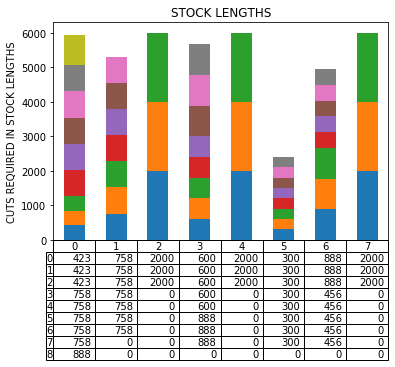

In [57]:
plt.figure()

df = pd.DataFrame(data).T
df = df.loc[(df!=0).any(axis=1)]
#df = df[(df.T != 0).any()]
df.plot.bar(legend=False, table=True, stacked=True, title='STOCK LENGTHS')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.xlabel('STOCK LENGTHS')
plt.ylabel('CUTS REQUIRED IN STOCK LENGTHS')
plt.show()

In [58]:
waste=L-df.sum(axis=1)
#print(df.sum(axis=1))

x = (df.sum(axis=1))
#print(x.sum(axis=0))
waste = waste.rename_axis("Waste for each stock length")
print(waste)
print('\n')
print("Total wasted \t= \t" + str(waste.sum(axis=0)))
print('% wasted \t= \t'+ '{0:.2f}'.format((waste.sum(axis=0))/(L*dy)*100))


Waste for each stock length
0      53
1     694
2       0
3     336
4       0
5    3600
6    1056
7       0
dtype: int64


Total wasted 	= 	5739
% wasted 	= 	10.63
